# Part 2 - SVD and PCA

In the previous part, we introduced you to dimensionality reduction and we showed you how to do simple feature selection, be it based on heuristics or statistical methods. But, as mentioned, these methods ignore information about interaction between features and can be over-simplified for our purposes. This is where algebra kicks in to help us out.

We're going to use the SVD and PCA methods to create new features from linear combinations of the original features. This procedure will allow us to significantly reduce the number of features and at the same time extract the most information from the data.

Never thought you'd use algebra again, right? Guess again, Neo.

![morpheus-algebra](./media/what-if-i-told-you.jpg)

In [1]:
import string
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from nltk.tokenize import WordPunctTokenizer
from scipy.sparse.linalg import svds
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2

plt.rcParams['figure.figsize']=(4.8,3.6)
seed = 42

## 1. Singular value decomposition

The Singular Value Decomposition (SVD) is a matrix decomposition or matrix factorization method, often used in applications such as compression, denoising and, our current topic, dimensionality reduction. All matrices have an SVD, making it more stable than other methods, such as the eigendecomposition. It is often used for Principal Component Analysis (PCA), which we are going to dive into later, but it can actually be used by itself, so let's start with that.

The concept of SVD is relatively straightforward, but it is useful to understand the algebra behind it. I was actually going to assume that you are fresh on your basic linear algebra (don't roll your eyes at me), skip the primers and jump right to business, but then again, a little refresher doesn't hurt. 

### 1.1 Basic linear algebra

<img src="media/welcome-to-the-matrix.jpg" width="400">

A matrix is just a collection of values ordered in rows and columns, such as the one that you created with the count or tfidf vectorizers.

$$
A = \begin{bmatrix} 
    x_{11}&x_{12}&.&.&.&.&x_{1N}\\
    x_{21}&x_{22}&.&.&.&.&x_{2N}\\
    .&.&.&.&.&.&.\\
    x_{M1}&x_{m2}&.&.&.&.&x_{MN}\\
\end{bmatrix}
$$

It has a known **shape** - in the case above M-by-N. Remember that a 1-by-N or M-by-1 shaped matrix is what we usually call a vector. There are also some typical operations that you can perform with the help of numpy, like the **transpose**

$$
A = \begin{bmatrix} 
    a & b & c\\
    d & e & f \\
\end{bmatrix}
\quad A^T = \begin{bmatrix} 
    a & d \\
    b & e \\
    c & f 
\end{bmatrix}
$$

or the **dot product**, where the internal dimensions have to match

$$
A = \begin{bmatrix} 
    a & b\\
\end{bmatrix} 
\quad B = \begin{bmatrix} 
    c \\ 
    d \\
\end{bmatrix} 
\quad AB = \begin{bmatrix} 
    ac + bd 
\end{bmatrix} 
\quad A^T B^T = \begin{bmatrix} 
    ac & ad \\ 
    bc & bd \\
\end{bmatrix}
$$

An important concept is the **determinant** of a matrix, an operation applicable to squared matrices that yields a scalar value. This value can be interpreted geometrically as the scaling factor of the linear transformation described by the matrix. For small matrices, like 2-by-2 and 3-by-3, the calculation is fairly simple:

$$ A = \begin{bmatrix} 
    a & b \\
    c & d \\
\end{bmatrix}
\quad|A| = ad − bc 
\quad \quad B = \begin{bmatrix} 
    a & b & c\\
    d & e & f \\
    g & h & i \\
\end{bmatrix}
\quad|B| = a(ei − fh) - b(di − fg) + c(dh − eg)
$$

But for matrices with higher numbers of rows or columns, these formulas will get complicated. If you wish to understand more about linear algebra, you'll have to study a bit. But for now, this should be enough to understand the mathematics behind the SVD. First, try out a few of these operations with numpy.

In [2]:
A = np.array([
    [1, 2],
    [3, 4],
    [1, 2],
    [1, 2],
    [3, 4],
    [1, 2],
])

# Print transpose
A_T = A.T
print(A_T)

# Use matrix multiplication
# np.multiply is the element-wise multiplication, while np.dot or np.matmul are matrix multiplications
A_mul = np.matmul(A, A_T)

# Compute determinant of 6x6 matrix
np.linalg.det(A_mul)

[[1 3 1 1 3 1]
 [2 4 2 2 4 2]]


np.float64(0.0)

### 1.2 Eigenvalues and eigenvectors

An **eigenvector** of a matrix is a vector whose direction remains unchanged when the linear transformation represented by that matrix is applied to it (in other words, it is invariant to the transformation). This means is that the product of this matrix $M$ with the eigenvector $v$ will just be a scaled version of $v$

$$Mv=\lambda v$$

where $\lambda$ is a scalar.

In this definition we exclude the zero-vector, since the multiplication is always true for any scalar $ \lambda $. A method for finding the vectors $v$ - the **eigenvectors** - and their scalar counterparts $\lambda$ - the **eigenvalues** - is to treat the above as a system of linear equations and solve it. You have seen how to solve linear equations manually and with numpy in BLU07, so we will not go deeper into this and just apply the corresponding numpy method.

In [3]:
# Compute eigenvalues and vectors of square matrix
lmbU, U = np.linalg.eig(A_mul)

print(lmbU)
print(U)

[ 6.95398321e+01 -9.90176513e-16  4.60167922e-01 -9.18223155e-18
  1.74874439e-31 -2.49849387e-34]
[[-2.65922637e-01 -8.66025404e-01  4.23420773e-01  3.33483686e-03
  -1.69557530e-02  1.35689874e-05]
 [-5.98807400e-01 -2.49334565e-15 -3.76071400e-01 -7.07101539e-01
   2.48238764e-01 -1.98655209e-04]
 [-2.65922637e-01  2.88675135e-01  4.23420773e-01 -1.11161229e-03
  -7.58709124e-01  6.07163511e-04]
 [-2.65922637e-01  2.88675135e-01  4.23420773e-01 -1.11161229e-03
   3.87832438e-01 -7.07416921e-01]
 [-5.98807400e-01 -2.32160803e-15 -3.76071400e-01  7.07101539e-01
  -2.48238764e-01  1.98655209e-04]
 [-2.65922637e-01  2.88675135e-01  4.23420773e-01 -1.11161229e-03
   3.87832438e-01  7.06796189e-01]]


### 1.3 Defining the singular value decomposition (SVD)

The SVD of a matrix $A$ is just its factorization into the product of three matrices, $U$, $S$, and $V$:

$$ A = USV^T $$
 
* $A$: matrix we want to decompose (consider $A$ an M-by-N matrix)
* $U$: orthonormal matrix composed by eigenvectors of  $AA^T$. These eigenvectors are also called the 'left-singular' values of A. ($U$ is M-by-M)
* $V^T$: orthonormal matrix composed by eigenvectors of $A^TA$. These eigenvectors are also called the 'right-singular' values of A. ($V$ is N-by-N)
* $S$: diagonal matrix containing the square root of nonzero eigenvalues of $U$ (or $V$), ordered by decreasing size ($S$ is M-by-N). It is a property of these matrices that the nonzero eigenvalues of $U$ and $V$ are the same, this is, the eigenvectors of  $AA^T$ and $A^TA$ are related. The statistical interpretation of eigenvalues is related to the variance in the data explained by the components each eigenvalue corresponds to (we'll get back to what this means later).

Orthonormal matrices have the following property: $VV^T = I$. This is, their product with their transpose produces the identity matrix.

Let's try to perform a decomposition. First, let's define a matrix A.

#### 1.3.1 Choose A

Let's create a very simple matrix  A, imagining that we have a bunch of reviews that we classify as positive or negative from the words that appear there.

|          |  like | hate | not | love |
|----------|-------|------|-----|------|
| Positive |  5    |  0   |  2  |   4  |
| Negative |  2    |  6	  |  1  |   2  |


You can see how this matrix can grow with the number of examples and the size of the vocabulary. Thus, you can understand why it is desirable to simplify it.

Start by defining the matrix:

In [4]:
A = np.array([
    [5, 0, 2, 4],
    [2, 6, 1, 2]
])

print("Matrix to decompose:")
print(A)

Matrix to decompose:
[[5 0 2 4]
 [2 6 1 2]]


Let's now create U, V, and S from what we learned above.

#### 1.3.2 Build U 

Remember that $U$ is composed by the eigenvectors of  $AA^T$.

In [5]:
AT = A.T
AAT = np.matmul(A, AT)

lmbU, U = np.linalg.eig(AAT)

print("\nEigenvectors:")
print(U)
print("\nEigenvalues:")
print(lmbU)


Eigenvectors:
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

Eigenvalues:
[65. 25.]


#### 1.3.3 Build $V^T$

Remember that $V^T$ is composed by the eigenvectors of  $A^TA$.

In [6]:
ATA = np.matmul(AT, A)

lmbV, V = np.linalg.eig(ATA)

print("\nEigenvectors:")
print(V)
print("\nEigenvalues:")
print(lmbV)


Eigenvectors:
[[-0.61394061  0.42426407 -0.61048658  0.05525028]
 [-0.52623481 -0.84852814 -0.05087388  0.00460419]
 [-0.26311741  0.14142136  0.66172683  0.86371563]
 [-0.52623481  0.28284271  0.43224482 -0.50092067]]

Eigenvalues:
[ 6.50000000e+01  2.50000000e+01 -5.79559478e-15  2.09774203e-16]


You can see that these are basically the same eigenvalues of $U$, padded with zero values at the end (or near-zero values because, well, computers). We are only missing $S$ now, so let's build it. 

#### 1.3.4 Create S

Take the square-root of the nonzero eigenvalues and place them on the diagonal of a M-by-N matrix, padding with zeros.

In [7]:
S_shape = A.shape

# Pick which lmb to use (higher rank)
lmb = lmbV if lmbV.shape[0] > lmbU.shape[0] else lmbU

# Cut off to the correct dimensions
S = np.sqrt(np.diag(abs(lmb))[:S_shape[0],:S_shape[1]])

print("S matrix:")
print(S)

S matrix:
[[8.06225775 0.         0.         0.        ]
 [0.         5.         0.         0.        ]]


You can now check that the factorization was successful and $A = USV^T$ 

In [8]:
print("Original matrix:")
print(A)

USVT = np.matmul(np.matmul(U, S), V.T)

print("\nFactorization U S V^T")
print(USVT)

Original matrix:
[[5 0 2 4]
 [2 6 1 2]]

Factorization U S V^T
[[-5.0000000e+00 -4.4408921e-16 -2.0000000e+00 -4.0000000e+00]
 [-2.0000000e+00 -6.0000000e+00 -1.0000000e+00 -2.0000000e+00]]


We got the same values as in the initial matrix, scaled by a factor of -1 (and of course the zeros are computer zeros). This is an ambiguity of the SVD problem, but there are ways to solve it. For our problem, since we are dealing with counts (if we are using CountVectorizer) or frequencies (TfidfVectorizer), the values must be positive, and we could simply use that information to disambiguate the sign:

In [9]:
sign = USVT.sum()/abs(USVT.sum())

print("Matrix sign:")
print(sign)

USVT_disambiguated = sign * USVT
print("\nFactorization U S V^T disambiguated:")
print(USVT_disambiguated)

Matrix sign:
-1.0

Factorization U S V^T disambiguated:
[[5.0000000e+00 4.4408921e-16 2.0000000e+00 4.0000000e+00]
 [2.0000000e+00 6.0000000e+00 1.0000000e+00 2.0000000e+00]]


Notice that this method to disambiguate is only valid in our context, but there are other ways of solving this problem.

If you want a deeper mathematical explanation you can start with this __[chapter](http://www.deeplearningbook.org/contents/linear_algebra.html)__, or if you've completely forgotten linear algebra and want to relearn it you can also try this __[course](https://ocw.mit.edu/courses/mathematics/18-06-linear-algebra-spring-2010/index.htm)__.

<img src="media/i-know-linear-algebra.jpg" width="300">

### 1.4 Using SVD for dimensionality reduction

Now that you know what's under the hood for SVD you probably want to make some use of it. We will show you how to use it to perform feature reduction. It is actually quite simple. Let's take a step back. Because of the orthonormal property of matrix $V$ we can write the SVD equation as:

$$ AV=US $$

We can now reduce $A$ to just one feature by truncating the $U$ and $V$ matrices to the first column and get the following:

$$ A\begin{bmatrix}v_{11}\\v_{21}\\.\\.\\v_{n1}\end{bmatrix} = s_{11}\begin{bmatrix}u_{11}\\u_{21}\\.\\.\\u_{m1}\end{bmatrix} $$

The vector $v$ is what we call a **projection direction**. The result of multiplying $A$ by this direction will result in a matrix with the same number of rows, but a smaller number of columns. Your data will now be projected into the first direction, corresponding to the highest eigenvalue (since they are ordered). This also corresponds to the component holding most variance (most information from the data). We could then get an approximation of $A$ by computing:

$$ A \approx s_{11}\begin{bmatrix}u_{11}\\u_{21}\\.\\.\\u_{m1}\end{bmatrix}\begin{bmatrix}v_{11}&v_{21}&.&.&v_{n1}\end{bmatrix} $$

You can extend this to any number of components. By selecting the first k eigenvalues in S and setting the others to zero, you can use any subselection to reconstruct an approximate version of  A, with:

$$ A^{*}=U^{*}S^{*}{V^{*}}^{T} $$

where $S^{*}$ is reduced to keep the first k eigenvalues and both $U^{*}$ and ${V^{*}}^{T}$ are reduced such that the dimensions are consistent. But this reconstruction isn't actually what we want. What we want is the projection of our data into a smaller space. In the same way that multiplying with one component gave us the data projected into that direction, we can multiply by k components and obtain the projections into k directions:

$$ A_r = A {V^{*}} $$

By selecting the first k eigenvalues we ensure that $A^{*}$ retains the most variance (information) from A; we have in effect compressed the original information and represented it using fewer features. This is often used in NLP and known in that context as LSA - **latent semantic analysis**.

### 1.5 Putting it all together

Let's put together all the steps into two handy functions:

In [10]:
def get_svd_decomposition(A):
    AT = A.T
    AAT = np.matmul(A, AT)
    ATA = np.matmul(AT, A)

    lmbU, U = np.linalg.eig(AAT)
    lmbV, V = np.linalg.eig(ATA)

    S_shape = A.shape
    lmb = lmbV if lmbV.shape[0] > lmbU.shape[0] else lmbU
    S = np.sqrt(np.diag(abs(lmb))[:S_shape[0],:S_shape[1]])
    
    return U, S, V


def get_svd_reduction_counts(A, n_components, debug=False):
    
    U, S, V = get_svd_decomposition(A)
    
    USVT = np.matmul(np.matmul(U[:, :n_components], S[:n_components, :n_components]), V.T[:n_components,:])
    
    # Assuming our initial matrix A holds counts or scaled counts
    sign = USVT.sum()/abs(USVT.sum())
    USVT_disambiguated = sign * USVT

    if debug:
        print("Reconstruction from {} components".format(n_components))
        print(USVT_disambiguated)

    reduction = np.matmul(A, V[:,:n_components])
    return reduction, V.T[:n_components,:]

As before, we start with a simple matrix A from a few reviews. We will now add two extra features that we'll define in an agnostic way regarding the positive/negative reviews. This means that the features do not hold much information about the classes.

|          |  like | hate | not | love | movie | book |
|----------|-------|------|-----|------|-------|------|
| Positive |  5    |  0   |  2  |   4  |   1   |   0  |
| Negative |  2    |  6	  |  1  |   2  |   0   |   1  |  
| Positive |  3    |  1   |  1  |   4  |   2   |   1  |
| Negative |  2    |  6	  |  1  |   5  |   0   |   2  |
| Negative |  0    |  0   |  3  |   1  |   0   |   0  |
| Negative |  2    |  4	  |  0  |   1  |   1   |   0  |

Let's define our matrix as a numpy array:


In [11]:
A = np.array([
    [5, 0, 2, 4, 1, 0],
    [2, 6, 1, 2, 0, 1],
    [3, 1, 1, 4, 2, 2],
    [2, 6, 1, 5, 0, 2],
    [0, 0, 3, 1, 0, 0],
    [2, 4, 0, 1, 1, 0],
])

We can now use our functions to get a feature reduction and compute the variance that each reduction holds.

In [12]:
variance = []

for n in range(6):
    A_red, VT = get_svd_reduction_counts(A, n_components=n+1)
    variance.append(1.0*np.var(A_red, axis=0).sum() / np.var(A, axis=0).sum())

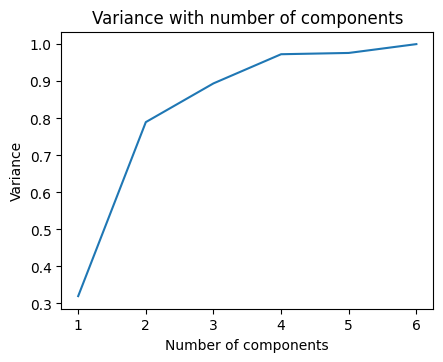

In [13]:
plt.plot(np.array([1.0*(n+1) for n in range(6)]), np.array(variance));
plt.title("Variance with number of components")
plt.xlabel("Number of components")
plt.ylabel("Variance");

As you see, the variance increases up to 4 features and then stabilizes. However, be aware that these four most important components are not the same four components in our table that hold the most information (like, hate, not, love).

Moreover, if some features in the original dataset are related, the whole dataset variance can be recovered with even less components. See what happens when we copy the values in "like" to "love" and "hate" to "not":

In [14]:
A = np.array([
    [5, 0, 0, 5, 1, 0],
    [2, 6, 6, 2, 0, 1],
    [3, 1, 1, 3, 2, 2],
    [2, 6, 6, 2, 0, 2],
    [0, 0, 0, 0, 0, 0],
    [2, 4, 4, 2, 1, 0],
])

variance = []

for n in range(6):
    A_red, VT = get_svd_reduction_counts(A, n_components=n+1)
    variance.append(1.0*np.var(A_red, axis=0).sum() / np.var(A, axis=0).sum())

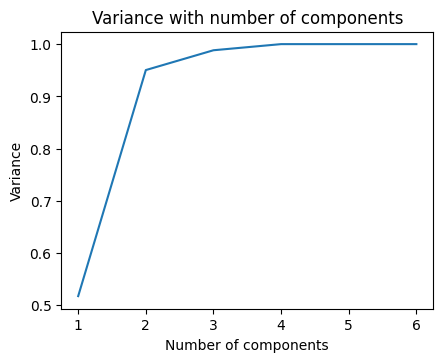

In [15]:
plt.plot(np.array([1.0*(n+1) for n in range(6)]), np.array(variance))
plt.title("Variance with number of components")
plt.xlabel("Number of components")
plt.ylabel("Variance");

In this case you can attribute most of the information in the data to only two components, at about 95%. As a rule of thumb, you should aim at keeping over 85% of the variance explained with the reduced features. So our 95% result is very good, and it should show you that the SVD actually extracts meaningful features from your data. Feeling pretty awesome there, Neo?

<img src="media/neo-dodging-bullets.jpg" width="400">


Unfortunately not all cases - in particular, real cases - are so straightforward. Instead of using our implementation, we will move to the scikit-learn version, the [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD) class. We will try it out with the data from the previous example.

## 2. SVD - NLP practical example using sklearn

### 2.1 Start from baseline

As before, start by importing the data set and getting a baseline. We will change from the multinomial naive Bayes to a classifier that can handle negative numbers because of the output of SVD. Let us use a nearest-neighbors classifier, which will try to classify the test points by their proximity to training examples. This is a very good illustration  of the usefulness of dimensionality reduction, since in very high-dimensional spaces, the data set becomes too sparse and the data points cannot be effectively clustered.

In [16]:
# Fetch dataset
df = pd.read_csv('./data/twitter_rep_dem_data_small.csv')

# Feature Extraction
handle_removal = lambda doc: re.subn(r'@\w+','', doc.lower())[0]
df['Tweet'] = df['Tweet'].map(handle_removal)

simple_tokenizer = lambda doc: " ".join(WordPunctTokenizer().tokenize(doc))
df['Tweet'] = df['Tweet'].map(simple_tokenizer)

train_data, test_data = train_test_split(df,  test_size=0.3, random_state=seed)
      
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data.Tweet)
X_test = vectorizer.transform(test_data.Tweet)

y_train = train_data.Party
y_test = test_data.Party

# Baseline
clf =  KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f'Number of features: {X_train.shape[1]}')
print('Accuracy: {}'.format(accuracy_score(y_pred, y_test)))

Number of features: 26219
Accuracy: 0.5062994960403168


That's a pretty low baseline, as expected. It is actually similar to just randomly attributing classes to the examples. Let's see if we can get more decent values by reducing the dimensionality of the data.

### 2.2 Applying SVD

We will now use the sklearn `truncatedSVD` class to obtain an SVD reduction of the data. This step might take a few minutes (>30 min), so just go ahead and grab a coffee, think about the nature of your reality, maybe try to bend some spoons, whatever makes you happy.

In [17]:
true_variance = []
explained_variance = []
explained_variance_ratio = []
accuracies = []

dense_X_train = X_train.toarray()
data_var = np.var(dense_X_train, axis=0).sum()

print('Total variance:')
print(data_var)

for n in [2, 10, 100, 200, 500, 1000]:
    print("\nComputing SVD for {} components".format(str(n)))
    svd = TruncatedSVD(n_components=n, random_state=seed)
    %timeit svd.fit(X_train)
    X_train_svd = svd.transform(X_train)
    X_test_svd =  svd.transform(X_test)
    print('\nVariance:')
    print(np.var(X_train_svd, axis=0).sum())
    true_variance.append(1.0*np.var(X_train_svd, axis=0).sum() / data_var)
    explained_variance.append(svd.explained_variance_)
    explained_variance_ratio.append(svd.explained_variance_ratio_)
    
    clf =  KNeighborsClassifier()
    clf.fit(X_train_svd, y_train)
    y_pred = clf.predict(X_test_svd)
    
    accuracies.append(accuracy_score(y_pred, y_test))
    print('Accuracy: {}'.format(accuracy_score(y_pred, y_test)))

Total variance:
0.9793720330999337

Computing SVD for 2 components
743 ms ± 140 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Variance:
0.007154528364969482
Accuracy: 0.5122390208783297

Computing SVD for 10 components
1.39 s ± 279 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.03136989245907973
Accuracy: 0.5556155507559395

Computing SVD for 100 components
15.3 s ± 1.66 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.15140485224906092
Accuracy: 0.6083513318934485

Computing SVD for 200 components
36.9 s ± 3.96 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.2233181598498146
Accuracy: 0.6108711303095752

Computing SVD for 500 components
The slowest run took 7.94 times longer than the fastest. This could mean that an intermediate result is being cached.
1min 3s ± 41.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.35643714950738736
Accuracy: 0.5932325413966882

Computing SVD for 1000 components
37 s ± 

Let's plot the variance contained in the SVD components and the accuracy of the model.

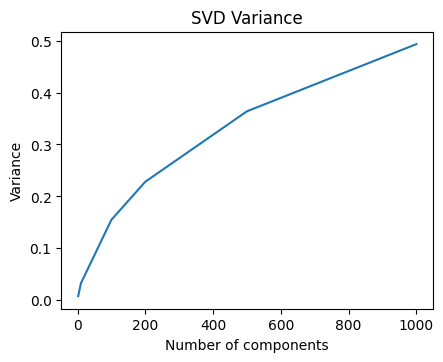

In [18]:
plt.plot(np.array([2.0, 10.0, 100.0, 200.0, 500.0, 1000.0]), np.array(true_variance));
plt.title("SVD Variance");
plt.xlabel("Number of components");
plt.ylabel("Variance");

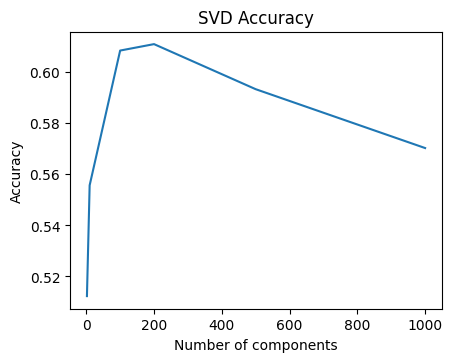

In [19]:
plt.plot(np.array([2.0, 10.0, 100.0, 200.0, 500.0, 1000.0]), np.array(accuracies));
plt.title("SVD Accuracy");
plt.xlabel("Number of components");
plt.ylabel("Accuracy");

These results show that high dimensionality can reduce the performance of the classifier. In this particular case, neither a high number of features nor a too low number of features result in good performance. Let's move forward to our second method, which is closely related to SVD - the principal component analysis - and see if the results hold.

**Note**: variance always increases because we just keep adding components, and each component will "explain" a bit more of the data's variance.

## 3. Principal component analysis

This idea of Principal Component Analysis is very similar to the one of SVD. In fact, SVD can be used just as a mathematical way of solving PCA and several numerical software libraries actually use SVD under the hood for their PCA routines - for example the scikit-learn implementation. So what is PCA?

In the same way as SVD, PCA aims to project the data into a lower dimensionality space, maximizing the variance of each projected component (which is the same as minimizing the reconstruction error). We need to introduce new concepts - the covariance matrix and the correlation matrix.

Given our training set as a sequence of data points $\{x^1, x^2, ..., x^K\}$, a matrix $A$ that represents this data set, and its mean as $\mu = \langle A \rangle$, the covariance matrix is represented by:

$$cov(A) = \langle(A - \mu)(A - \mu)^T\rangle = \frac{(A - \mu)(A - \mu)^T}{n-1}$$

where each row is a variable and each column an observation, and the correlation matrix is simply

$$corr(A) = \langle A A^T\rangle$$

In the study of principal components, we are interested in the variation of the data about the mean, so we first need to center the data

$$ \bar{A} = A - \mu$$

with the result that $cov(\bar{A}) = corr(\bar{A})$, since the data will have zero mean.

### 3.1 Getting the first principal component

We can now define the first principal component as the projection of the data in some direction represented by the vector $\textbf{w}$:

$$p_1 = \textbf{w}^T \bar{A}$$

You can write out the first component as a function of the eigenvectors and eigenvalues of the covariance matrix of $\bar{A}$ if these are ordered from highest eigenvalue to lowest 

$$p_1 = \textbf{v}_1 \bar{A}$$

The variance associated with this component will be

$$\sigma^2_{p_1} = \lambda_1$$

This can be extended to the rest of the components, so the procedure to get a PCA reduction is quite simple. Below we derive these expressions in more detail. You can skip to section 3.1.1 for the practical example if you don't feel comfortable in linear algebra.

We choose the vector $\textbf{w}$ to maximize the variance of $p_1$

$$\sigma^2_{p_1} = \langle p_1^2 \rangle = \langle (\textbf{w}^T \bar{A})(\bar{A}^T\textbf{w}) \rangle = \textbf{w}^T \langle \bar{A} \bar{A}^T\rangle \textbf{w} = \textbf{w}^T cov(A) \textbf{w} $$

If we define $\textbf{w}$ as a linear combination of the eigenvectors of the covariance matrix, with weights $w_i$ and eigenvectors $\textbf{v}_i$, we get

$$\textbf{w} = \sum_i{w_i \textbf{v}_i}$$

$$\sigma^2_{p_1} = \textbf{w}^T cov(A) (\sum_i{w_i \textbf{v}_i}) = \sum_i{w_i \textbf{w}^T cov(A)\textbf{v}_i}$$

Remember that one of the main properties of eigenvectors is that their direction remains unchanged when applying the linear transformation $Mv=\lambda v$. Also note that, if $\textbf{v}_i$ are vectors from an orthonormal basis, then $\textbf{v}_i\textbf{v}_j = 0$ and $\textbf{v}_i\textbf{v}_i = 1$, so we can write:

$$\textbf{w}^T \textbf{v}_i = w_i $$

And the previous result simplifies to

$$\sigma^2_{p_1} = \sum_i{w_i \lambda_i \textbf{w}^T \textbf{v}_i} = \sum_i{w_i^2 \lambda_i}  $$

This is the quantity we want to maximize, constrained to $\sum_i{w_i^2} = 1 $, so it should be clear that the maximum should be attained by setting $w_i = 1$ for the highest eigenvalue of $cov(A)$ and zero to all other weights. The first component will then be:

$$ p_1 = \textbf{v}_1 \bar{A}$$

And a reconstruction of $\bar{A}$ is obtained by:

$$ \bar{A} =  p_1 \textbf{v}_1$$

The variance of this compoment will just be $\sigma^2_{p_1} = \lambda_i$ for the highest eigenvalue.

Now we show PCA on a practical example.

#### 3.1.1 Choose A

Let's reuse the same matrix  A that we had before:

|          |  like | hate | not | love |
|----------|-------|------|-----|------|
| Positive |  5    |  0   |  2  |   4  |
| Negative |  2    |  6	  |  1  |   2  |

In [20]:
A = np.array([
    [5, 0, 2, 4],
    [2, 6, 1, 2]
])

print("\nMatrix to decompose:")
print(A)


Matrix to decompose:
[[5 0 2 4]
 [2 6 1 2]]


#### 3.1.2 Center A and compute the covariance matrix

We first need to center our data. Be careful with the averaging dimension - you want to average across samples and get a vector with the size of your feature space. Then we can compute the covariance matrix: 

In [21]:
u = np.mean(A, axis=0)

centA = A - u

print("\nCentered data:")
print(centA)

# The covariance is an average of (A - u)(A -u)^T 
covA = np.matmul(centA.T, centA)/A.shape[0]

print("\nCovariance Matrix:")
print(covA)


Centered data:
[[ 1.5 -3.   0.5  1. ]
 [-1.5  3.  -0.5 -1. ]]

Covariance Matrix:
[[ 2.25 -4.5   0.75  1.5 ]
 [-4.5   9.   -1.5  -3.  ]
 [ 0.75 -1.5   0.25  0.5 ]
 [ 1.5  -3.    0.5   1.  ]]


#### 3.1.3 Get the covariance matrix eigenvalues 

In [22]:
lmbV, V = np.linalg.eig(covA)
print(V)

[[-0.90553851 -0.42426407  0.90553851 -0.14142136]
 [-0.39755349  0.84852814  0.39755349  0.28284271]
 [ 0.06625892 -0.14142136 -0.06625892  0.42426407]
 [ 0.13251783 -0.28284271 -0.13251783  0.84852814]]


#### 3.1.4 Project data into the first component

In [23]:
A_red = np.matmul(centA, V[:, 0])

print(A_red)

[ 2.22044605e-16 -2.22044605e-16]


### 3.2 Putting it all together

Let's put these steps together in a function:

In [24]:
def get_pca_reduction(A, n_components):
    
    u = np.mean(A, axis=0)
    covA = np.matmul(A.T, A)
    lmbV, V = np.linalg.eig(covA)
    V_red = V[:,:n_components]
    A_red = np.matmul(A, V_red)
    var = lmbV

    return A_red, V_red, var

Once again, we are going to reuse the matrix from the SVD example:

|          |  like | hate | not | love | movie | book |
|----------|-------|------|-----|------|-------|------|
| Positive |  5    |  0   |  2  |   4  |   1   |   0  |
| Negative |  2    |  6	  |  1  |   2  |   0   |   1  |  
| Positive |  3    |  1   |  1  |   4  |   2   |   1  |
| Negative |  2    |  6	  |  1  |   5  |   0   |   2  |
| Negative |  0    |  0   |  3  |   1  |   0   |   0  |
| Negative |  2    |  4	  |  0  |   1  |   1   |   0  |

Let's define our matrix as a numpy array:

In [25]:
A = np.array([
    [5, 0, 2, 4, 1, 0],
    [2, 6, 1, 2, 0, 1],
    [3, 1, 1, 4, 2, 2],
    [2, 6, 1, 5, 0, 2],
    [0, 0, 3, 1, 0, 0],
    [2, 4, 0, 1, 1, 0],
])

We will now plot the variance and see the variance of the different components.

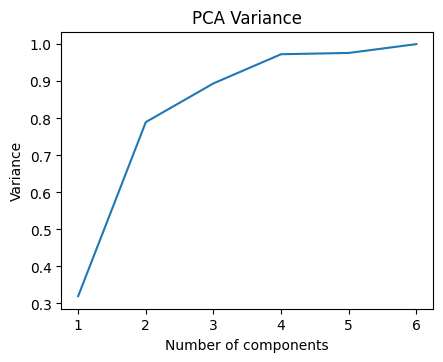

In [26]:
variance = []

for n in range(6):
    A_red, V, var = get_pca_reduction(A, n_components=n+1)
    variance.append(1.0*np.var(A_red, axis=0).sum() / np.var(A, axis=0).sum())

plt.plot(np.array([1.0*(n+1) for n in range(6)]), np.array(variance));
plt.title("PCA Variance");
plt.xlabel("Number of components");
plt.ylabel("Variance");

Again, the last two components don't bring much information.

## 4. PCA - NLP practical example using sklearn

### 4.1 Start from baseline

We will now go back to our real data. We'll start from the same baseline as in section 2.1.

In [27]:
df = pd.read_csv('./data/twitter_rep_dem_data_small.csv')

# Feature Extraction
handle_removal = lambda doc: re.subn(r'@\w+','', doc.lower())[0]
df['Tweet'] = df['Tweet'].map(handle_removal)

simple_tokenizer = lambda doc: " ".join(WordPunctTokenizer().tokenize(doc))
df['Tweet'] = df['Tweet'].map(simple_tokenizer)

train_data, test_data = train_test_split(df, test_size=0.3, random_state=seed)
      
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data.Tweet)
X_test = vectorizer.transform(test_data.Tweet)

y_train = train_data.Party
y_test = test_data.Party

clf =  KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f'Number of features: {X_train.shape[1]}')
print('Baseline Accuracy: {}'.format(accuracy_score(y_pred, y_test)))

Number of features: 26219
Baseline Accuracy: 0.5062994960403168


### 4.2 Applying PCA

Now we use the scikit learn [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to reduce the features. Once again, go grab that coffee and take a walk, 'cause this might take a while. You might want to leave out the 1000 components if you have a slower computer because that one takes ages.

In [28]:
variance = []
accuracies = []

dense_X_train = X_train.toarray()
dense_X_test = X_test.toarray()
data_var = np.var(dense_X_train, axis=0).sum()

print('Total variance:')
print(data_var)

for n in [2, 10, 100, 200, 500, 1000]:
    print("\nComputing PCA for {} components".format(str(n)))
    pca = PCA(n_components=n, random_state=seed)
    %timeit pca.fit(dense_X_train)
    X_train_pca = pca.transform(dense_X_train)
    X_test_pca = pca.transform(dense_X_test)
    
    print('\nVariance:')
    print(np.var(X_train_pca, axis=0).sum())
    variance.append(1.0*np.var(X_train_pca, axis=0).sum() / data_var)
    
    clf =  KNeighborsClassifier()
    %timeit clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    
    accuracies.append(accuracy_score(y_pred, y_test))
    print('\nAccuracy: {}'.format(accuracy_score(y_pred, y_test)))

Total variance:
0.9793720330999337

Computing PCA for 2 components
12.5 s ± 237 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.00884329242347785
14.2 ms ± 378 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Accuracy: 0.5260979121670266

Computing PCA for 10 components
14.8 s ± 240 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.032669085753682665
26.4 ms ± 847 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Accuracy: 0.5413966882649388

Computing PCA for 100 components
47.1 s ± 674 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.1525721676515528
10.1 ms ± 134 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Accuracy: 0.6042116630669546

Computing PCA for 200 components
1min 23s ± 661 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.22463714266185258
10.8 ms ± 152 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Accuracy: 0.6101511879049676

Computing PCA for 500 components
4

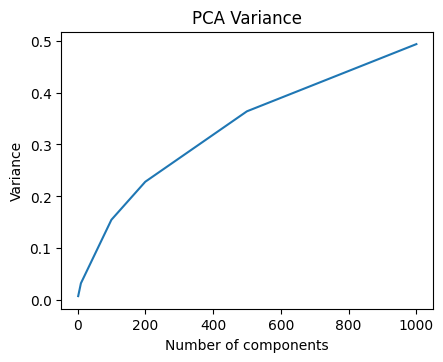

In [29]:
plt.plot(np.array([2.0, 10.0, 100.0, 200.0, 500.0, 1000.0]), np.array(true_variance));
plt.title("PCA Variance");
plt.xlabel("Number of components");
plt.ylabel("Variance");

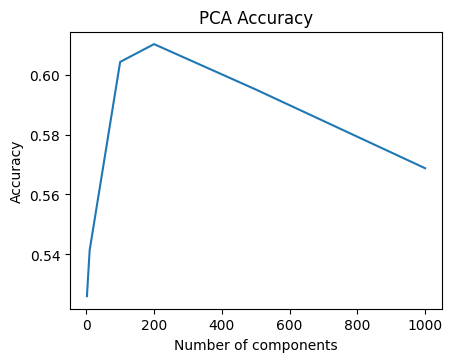

In [30]:
plt.plot(np.array([2.0, 10.0, 100.0, 200.0, 500.0, 1000.0]), np.array(accuracies));
plt.title("PCA Accuracy");
plt.xlabel("Number of components");
plt.ylabel("Accuracy");

The results are similar to the ones obtained with SVD, which is intuitive since both methods try to obtain meaningful components that represent the data. As mentioned before, the use of nearest-neighbors classifier highlights the problems of high dimensional data, and should show you that dimension reduction methods can be very useful in solving that problem.

## 5. Final Remarks

We went through PCA and SVD in this notebook, which are methods you can try out with virtually any kind of data, whether your purpose is compression, visualization or just dimensionality reduction for classification. Some final notes:

1 - The performance of the methods is tightly coupled to the classifier you choose. So think about the classifier before trying to improve performance with dimension reduction.

2 - You can combine methods like this with other feature selection and engineering techniques. As in many fields, trying out these techniques in different scenarios will give you a better feeling of when they can be helpful or harmful.

We're finally done! Now rest a bit, go for a walk, and then dive into Part 3. But before you go, I'll leave you with these questions:

<img src="media/matrix-questions-existencial.jpg" width="700">